# Required MBTA zoning changes

Like most communities in MA with a housing shortage, Waltham has to change our zoning to allow a certain amount of density by-right in order
to comply with the MBTA Communities law.

This [page](https://www.mass.gov/info-details/compliance-model-components) has an Excel workbook that helps communities to pinpoint which restrictions
they might have in place that prevent MFH housing from being constructed around transit areas, as required by the law.

After the community is selected, a few housing required parameters will auto-populate (pre-calculated developable land amounts, required housing units etc.)
and the person filling out the workbook needs to define one or more districts that will be re-zoned to fulfill the requirement. The other sheets of the Excel
workbook allow entering restrictions like setbacks or floor area ratios and will flag requirements that need to be relaxed in order for the calculation to work.

In [46]:
import pandas as pd
import geopandas as geo_pd
from io import BytesIO
from zipfile import ZipFile
from dbfread import DBF

from dvc.api import DVCFileSystem

fs = DVCFileSystem("https://github.com/tjrileywisc/waltham_etl")

In [47]:
requirements = {
    "Community" : "Waltham",
    "Community category" : "Commuter Rail",
    "2020 Housing Units" : 26545,
    "Minimum multi-family unit capacity": 3982,
    "Minimum land area" : 50,
    "Developable station area" : 470,
    "% of district to be located in station area" : 50
}

MBTA_DENSITY = 15
SQ_FT_IN_ACRE = 43560

In [48]:
with fs.open("data/mbta_communities/308_WALTHAM_detail.zip") as f:
    content = BytesIO(f.read())
    zip = ZipFile(content)
    zip.extractall("../../data/mbta_communities/308_WALTHAM_detail")
    property_shapefiles_df = geo_pd.read_file("../../data/mbta_communities/308_WALTHAM_detail/308_WALTHAM_detail.shp")

property_shapefiles_df.drop(axis="columns", labels=["Owner"], inplace=True)

property_shapefiles_df["UseCodes"] = property_shapefiles_df["UseCodes"].astype(str)
property_shapefiles_df.head()

,LOC_ID,Address,UseCodes,UseDesc,TRANSIT,ACRES,SQFT,PublicInst,NonPubExc,Tot_Exclud,...,Wetlands,TitleV,Wellhead1,Flood_SHFA,Farmland,SurfWatBC,Wellhead2,IntWellhea,Habitat,geometry
0,F_720576_2954833,"726 SOUTH ST, SOUTH ST, WALTHAM, 02453",903,(formerly Municipalities/Districts. Removed J...,Y,0.268435,11693.049406,11693.792788,2343.604743,11693.792788,...,0.000000,2286.888339,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,"POLYGON ((219693.364 900605.105, 219632.899 90..."
1,F_722539_2954565,"167 EDGEWATER DR, EDGEWATER DR, WALTHAM, 02453",101,Single Family Residential,N,3.760119,163790.789897,0.000000,112055.168152,112055.168152,...,90234.398162,19056.802159,0.0,119268.637810,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220199.657 900534.011, 220212.276 90..."
2,F_722274_2954887,"105 EDGEWATER DR, EDGEWATER DR, WALTHAM, 02453",101,Single Family Residential,Y,0.552854,24082.340199,0.000000,906.091999,906.090355,...,23.357678,906.091999,0.0,2650.988149,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220183.593 900647.010, 220142.145 90..."
3,F_722477_2954895,"44 RIVERSIDE DR, RIVERSIDE DR, WALTHAM, 02453",101,Single Family Residential,Y,0.347326,15129.509686,0.000000,3468.070430,3468.070430,...,0.000000,3468.070430,0.0,2245.188236,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220232.880 900672.543, 220232.576 90..."
4,F_722168_2954973,"85 KNOLLWOOD DR, KNOLLWOOD DR, WALTHAM, 02453",101,Single Family Residential,Y,0.278369,12125.747026,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,"POLYGON ((220137.309 900682.421, 220131.801 90..."


In [49]:
city_id = 308
city = "WALTHAM"
CY = 22
FY = 23

with fs.open(f"data/gis/L3_SHP_M{city_id}_{city}.zip") as f:
    content = BytesIO(f.read())
    zipfile = ZipFile(content)
    zipfile.extractall("../../data/gis")
    shp_path = f"../../data/gis/L3_SHP_M{city_id}_{city}/M{city_id}TaxPar_CY{CY}_FY{FY}.shp"
    #assesments_df = geo_pd.read_file(shp_path)
    
    assessments_table = DBF(f"../../data/gis/L3_SHP_M{city_id}_{city}/M{city_id}Assess_CY{CY}_FY{FY}.dbf", load=True)
    assessments_df = pd.DataFrame([dict(r) for r in assessments_table.records])

In [50]:
assessments_df.columns

Index(['PROP_ID', 'LOC_ID', 'BLDG_VAL', 'LAND_VAL', 'OTHER_VAL', 'TOTAL_VAL',
       'FY', 'LOT_SIZE', 'LS_DATE', 'LS_PRICE', 'USE_CODE', 'SITE_ADDR',
       'ADDR_NUM', 'FULL_STR', 'LOCATION', 'CITY', 'ZIP', 'OWNER1', 'OWN_ADDR',
       'OWN_CITY', 'OWN_STATE', 'OWN_ZIP', 'OWN_CO', 'LS_BOOK', 'LS_PAGE',
       'REG_ID', 'ZONING', 'YEAR_BUILT', 'BLD_AREA', 'UNITS', 'RES_AREA',
       'STYLE', 'STORIES', 'NUM_ROOMS', 'LOT_UNITS', 'CAMA_ID', 'TOWN_ID'],
      dtype='object')

In [51]:
# filter out 'non-transit' marked parcels
property_shapefiles_df = property_shapefiles_df[property_shapefiles_df["TRANSIT"] == "Y"]

In [52]:
property_shapefiles_df = property_shapefiles_df.merge(assessments_df, on="LOC_ID", how="inner")

In [53]:
# TODO
# remove parcels that are not going to be selected or unlikely to be selected

# government buildings

# transit, ROW

# greenspace, river, etc.

In [54]:
property_shapefiles_df.columns

Index(['LOC_ID', 'Address', 'UseCodes', 'UseDesc', 'TRANSIT', 'ACRES', 'SQFT',
       'PublicInst', 'NonPubExc', 'Tot_Exclud', 'Tot_Sensit', 'ROW',
       'OpenSpace', 'Hydrology', 'Wetlands', 'TitleV', 'Wellhead1',
       'Flood_SHFA', 'Farmland', 'SurfWatBC', 'Wellhead2', 'IntWellhea',
       'Habitat', 'geometry', 'PROP_ID', 'BLDG_VAL', 'LAND_VAL', 'OTHER_VAL',
       'TOTAL_VAL', 'FY', 'LOT_SIZE', 'LS_DATE', 'LS_PRICE', 'USE_CODE',
       'SITE_ADDR', 'ADDR_NUM', 'FULL_STR', 'LOCATION', 'CITY', 'ZIP',
       'OWNER1', 'OWN_ADDR', 'OWN_CITY', 'OWN_STATE', 'OWN_ZIP', 'OWN_CO',
       'LS_BOOK', 'LS_PAGE', 'REG_ID', 'ZONING', 'YEAR_BUILT', 'BLD_AREA',
       'UNITS', 'RES_AREA', 'STYLE', 'STORIES', 'NUM_ROOMS', 'LOT_UNITS',
       'CAMA_ID', 'TOWN_ID'],
      dtype='object')

In [55]:
# potential total units on remaining parcels, assuming they can be fully developed
property_shapefiles_df["POTENTIAL"] = (property_shapefiles_df["ACRES"] * MBTA_DENSITY).astype(int)
print(int(property_shapefiles_df["POTENTIAL"].sum()))

28163


In [56]:
# what's the gap between what's built and what the new by-right zoning would potentially allow?
property_shapefiles_df["GAP"] = property_shapefiles_df["POTENTIAL"] - property_shapefiles_df["UNITS"]

In [57]:
property_shapefiles_df["GAP"].value_counts()

 0       540
 1       485
-1       373
 2       272
-2       184
        ... 
-201       1
-233       1
 20        1
-78        1
 9247      1
Name: GAP, Length: 113, dtype: int64

<Axes: >

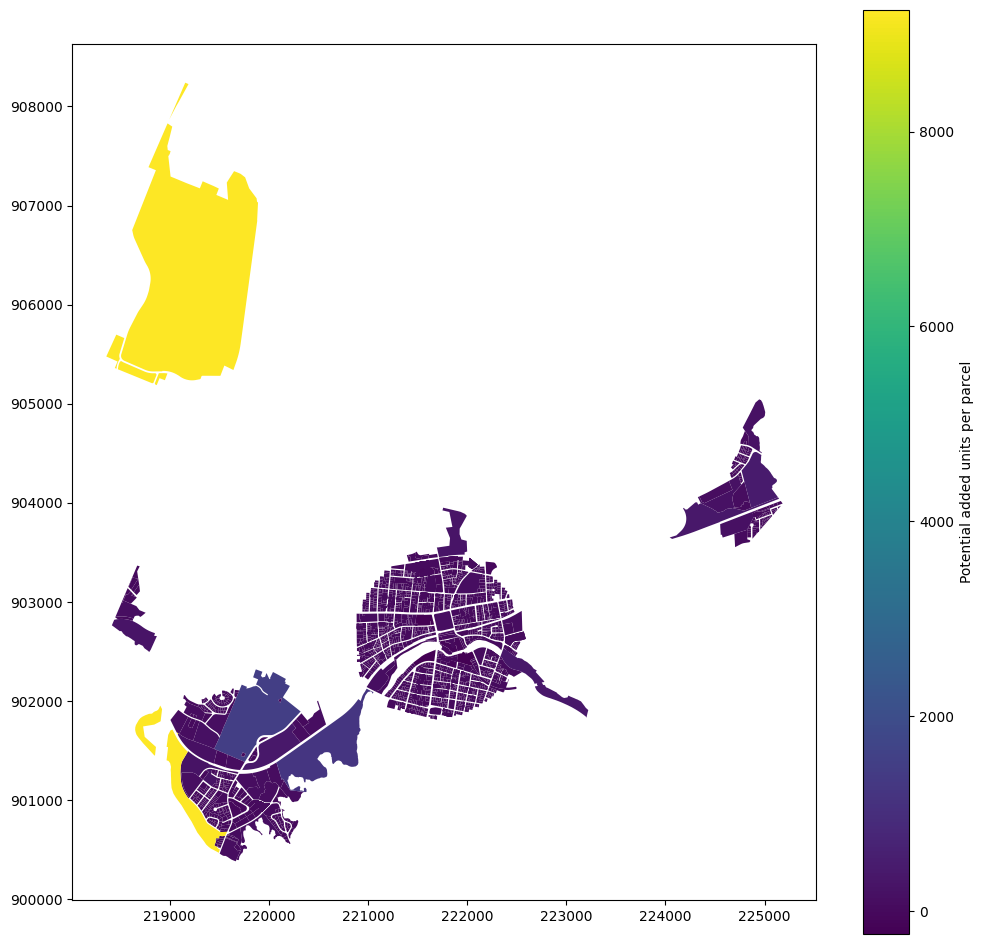

In [58]:
property_shapefiles_df.plot(column="GAP", legend=True, legend_kwds={'label': "Potential added units per parcel"}, figsize=(12, 12))

# Checklist parameters tab

Here the user enters existing restrictions on height, lot sizes, etc.

In [59]:
districts = [
    {"name": "Carter"},
    {"name": "Brandeis"}
]

In [60]:
class District:
    pass

    def __init__(self, min_parcel_size, required_open_space_frac, parking_ratio, max_units_per_acre, max_lot_coverage_frac, max_building_stories, far, addl_lot_sq_ft_by_dwelling_unit):
    
        self.parcels = []

class Parcel:
    
    def __init__(self, parcel_size, district):
        self.parcel_size = parcel_size
        self.district = district

In [61]:
# functions from district tabs

def developable_parcel_sf(min_parcel_size, parcel_size, excluded_size):
    """_summary_

    Args:
        min_parcel_size (float): minimum parcel size set in district
        parcel_size (float)    : actual parcel lot size
        excluded_size(float) : excluded buildable area of the parcel
        
    """

    if parcel_size < min_parcel_size:
        return 0
    
    return min(parcel_size - excluded_size, 0)

def developable_sqft_for_unit():
    if override_dev_sqft > 0:
        return override_dev_sqft
    
    return developable_parcel_sf

def open_space_required(required_open_space_frac):
    """_summary_

    Args:
        required_open_space_frac (float):
            district required open space fraction
    """
    # I'm surprised about the maximum fraction set here by default
    return max(0.2, required_open_space_frac)


def open_space_removed():
    """_summary_
    """

    if override_dev_sqft == 0:
        if allows_restricted_areas:
            return max(excluded_land_frac, open_space_required) * parcel_size
        else:
            return (excluded_land_frac + open_space_required) * parcel_size
    
    return developable_sqft_for_unit * open_space_required


def model_parking_ratio(district_parking_ratio):
    """_summary_

    Args:
        district_parking_ratio (_type_): _description_
    """
    if district_parking_ratio == 0:
        return 0
    elif district_parking_ratio >= 0.01 and district_parking_ratio <= 0.5:
        return 0.3
    elif district_parking_ratio >= 0.51 and district_parking_ratio <= 1.0:
        return 0.45
    elif district_parking_ratio >= 1.01 and district_parking_ratio <= 1.25:
        return 0.55
    elif district_parking_ratio >= 1.26 and district_parking_ratio <= 1.5:
        return 0.6
    elif district_parking_ratio >= 1.51:
        return 0.65


def parking_area_removed(parcel_size):
    """_summary_
    """

    if developable_sqft_for_unit > 0:
        return (parcel_size - open_space_removed) * model_parking_ratio
    
    return 0

def building_footprint(parcel_size):

    if developable_sqft_for_unit == 0:
        return 0
    
    return parcel_size - open_space_removed - parking_area_removed

def building_envelope():

    if building_footprint > 0:
        return building_footprint * max_building_stories
    
    return 0

# unit capacity tests (i.e. NIMBY's playground)

def modeled_unit_capacity():

    if building_envelope / 1000 > 3:
        return int(building_envelope / 1000)
    else:
        if building_envelope / 1000 > 2.5 and building_envelope / 1000 <= 3:
            return 3
    
    return 0

def dwelling_units_per_acre_limit():

    if max_units_per_acre:
        return (parcel_size / SQ_FT_IN_ACRE) * max_units_per_acre
    
    return None

def max_lot_coverage_limit():

    if max_lot_coverage_frac:
        return (parcel_size * max_lot_coverage_frac) * max_building_stories / 1000
    
    return None

def lot_area_per_dwelling_limit():

    if lot_area_per_dwelling_unit:
        return parcel_size / lot_area_per_dwelling_unit
    
    return None

def far_limit():

    if far:
        return parcel_size * far / 1000
    
    return None

def max_units_per_lot_limit():

    if not max_units_per_lot:
        return modeled_unit_capacity
    elif max_units_per_lot < modeled_unit_capacity and max_units_per_lot >= 3:
        return max_units_per_lot
    elif max_units_per_lot < modeled_unit_capacity and max_units_per_lot < 3:
        return 0
    
    return modeled_unit_capacity

def is_non_conforming_lot():

    if parcel_size < minimum_lot_size and parcel_size > 0:
        return True
    
    return False

def max_units_based_on_addl_lot_size_reqs():

    if is_non_conforming_lot:
        return 0

    if not addl_lot_sq_ft_by_dwelling_unit:
        return "<no limit>" # TODO: how to render this?

    return int(((parcel_size-base_lot_size)/addl_lot_sq_ft_by_dwelling_unit)+1)


# unit compliance

def final_lot_mf_unit_capacity():

    min_constraints = min(modeled_unit_capacity, dwelling_units_per_acre_limit, max_lot_coverage_limit, lot_area_per_dwelling_limit, far_limit, max_units_per_lot_limit) 

    if min_constraints < 2.5:
        return 0
    elif min_constraints >= 2.5 and min_constraints < 3:
        return 3
    return int(min_constraints)

def du_per_ac():

    return SQ_FT_IN_ACRE * final_lot_mf_unit_capacity / parcel_size


# Running the optimizer in NIMBY mode vs. YIMBY mode

NIMBYs who are likely to be unhappy with any sort of construction are going to try their best to select parcels resulting in the smallest amount possible ever getting constructed-
this would be parcels either far away from any existing conveniences (delaying construction or at least making it more costly to developers), or parcels where the already built structures are nearly the target density, so even if something were built the impact would be minimial.

A YIMBY is likely to select parcels resulting in the maximum amount of units created (SFH homes likely to be doomed, but they should be since they're squatting on prime real estate near transit!)
Though really a YIMBY is probably just going to remove as much of the zoning as they could probably get away with, which could result in as much as a sweet 25,000+ units for Waltham at the target density. But let's say all you can get away with is the zoning for the minimum number of parcels to match the required unit count before the NIMBYs come with their pitchforks.

So the dueling objectives we'll set here are NIMBYs looking for nearly full parcels and YIMBYs looking for nearly emtpy parcels.

Note - since NIMBYism is the historic problem here, the MA state government made their job harder by requiring that the districts be contiguous. They can't just cherry pick parcels where nothing will be built, but I'm sure they'll try. To try and capture this requirement, the model will select a parcel in the area that is the closest to the respective groups' objective and branch out from there.

In [62]:
# TODO
# assuming zoning to 15 units / acre, calculate the number of units that would be created, and get the difference from the actual existing number of units

# it would be interesting to see the potential net increase but it would also select which parcels might be the best targets for each group

# District 1 (Carter St)

This is going to be the main lot